# Garden Path Sentences in OpenAI Transformer Model
#### Benjamin Newman - blnewman@stanford.edu

This notebook takes a quick look at the syntactic abilities of the model proposed in Recford et al.'s paper ["Improving Language Understanding by Generative Pretraining"](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf). Their model is a transformer-based and attempts to create a universal representation for language that can be fine-tuned later for task-specific tasks. 

Transformational architectures have shown promise in parsing [Kitaev & Klein, 2018](https://arxiv.org/abs/1805.01052) and BERT has been shown to perform very well at syntactic tasks as well [Goldberg, 2019](https://arxiv.org/pdf/1901.05287.pdf), and I thought it would be interesting to look at how this particular one deals with garden path sentences. Goldberg's write-up focussed solely on BERT, but unfortunately (or fortunately for it) BERT is a bidirectional language model. This changes the meaning of surprisal and perplexity, and as these are the basis for the observations described here, so such bidirectional models are avoided.

Garden path sentences are usually studied in the psycholinguistics literature when asking questions about how humans parse natural language. They are sentences that at first present a relatively innocuous parsing problem but then suddenly confuse the reader. Some examples include:

- "The old man the boat"
- "The horse raced past the barn fell"
- "The child pushed through the crowd cried for his mother"

One of the more common ways to create these kinds of sentences is to start with a sentence with a relative clause and drop the "that" forming a reduced relative clause. For example, "the horse *that* raced past the barn fell" become "the horse raced past the barn fell." The past participle and the past tense have to be the same form and the verb should ideally be one that could easily be construed to take a subject.

This write-up was also inspired by [Hale et al., 2018](https://arxiv.org/pdf/1806.04127.pdf)'s work showing that information-theoretic measurements from the beam of a Recurrent Neural Network Grammars (RNNG) parser correlates with EEG results in humans. They were able to demonstrate that high surprisal co-occured with early EEG effects and parser distance co-occured with P600 effects in human listeners. These are effects correlated with grammatical mistakes are difficulties in humans.

The code is all below. The OpenAI UGP model and weights were downloaded from [https://github.com/huggingface/pytorch-openai-transformer-lm].


In [16]:
from model_pytorch import TransformerModel, load_openai_pretrained_model, DEFAULT_CONFIG, LMModel
import torch
import math
import numpy as np
from matplotlib import pyplot as plt
from text_utils import TextEncoder

In [4]:
# set up the encoder to turn words into indices
encoder_path = 'model/encoder_bpe_40000.json'
bpe_path = 'model/vocab_40000.bpe'

text_encoder = TextEncoder(encoder_path, bpe_path)

nvocab = len(text_encoder.encoder)
nctx = 512 # number of positional embeddings (context)
vocab = nvocab + nctx

In [8]:
# load language modeling model with default arguments except return_probs set to true
# so we can get access to language model probabilities to calculate perplexity and surprisal
args = DEFAULT_CONFIG
lm_model = LMModel(args, vocab, nctx, return_probs = True)
load_openai_pretrained_model(lm_model.transformer, n_ctx=nctx, n_special=0)

lm_model.eval()

Loading weights...


In [11]:
# make_batch from generate.py
# generates the input to the language model from a list of token ids (X)

def make_batch(X):
    X = np.array(X)
    assert X.ndim in [1, 2]
    if X.ndim == 1:
        X = np.expand_dims(X, axis=0)
    # add positional encodings - just second dimension that says which word is where
    pos_enc = np.arange(nvocab, nvocab + X.shape[-1])
    pos_enc = np.expand_dims(pos_enc, axis=0)
    batch = np.stack([X, pos_enc], axis=-1)
    batch = torch.tensor(batch, dtype=torch.long)
    return batch

Now that all the set-up is done (that was fast!), we can start using the language model.

In [307]:
def get_top_k_nw(sent, k=10, verbose=True):
    """
    Prints out the top k most probable next word continuations of the sentence sent
    """
    sent_vec = text_encoder.encode([sent])
    sent_batch = make_batch(sent_vec)
    sent_res = lm_model(sent_batch)
    
    # get top k next words with probabilities
    probs, decode = sent_res[:,-1,:].topk(k)  
    if verbose:
        print(sent)
        for p, d in zip(probs.flatten(), decode.flatten()):
            print("\t...%s (%.4f)"%(text_encoder.decoder[d.item()], p.item()))
    
    words = [text_encoder.decoder[d.item()] for d in decode.flatten()]
    for i in range(len(words)):
        if words[i][-4:] == "</w>":
            words[i] = words[i][:-4]
    return probs.flatten().detach().numpy(), words
        
    

Now we can see it in action. The <\w\> at the end signify the end of legal words

In [308]:
get_top_k_nw("I am a ", 8)

I am a 
	...man</w> (0.0315)
	...little</w> (0.0237)
	...good</w> (0.0196)
	...vampire</w> (0.0186)
	...very</w> (0.0158)
	...woman</w> (0.0149)
	...bit</w> (0.0119)
	...doctor</w> (0.0079)


(array([0.03153032, 0.02369728, 0.01955679, 0.01861425, 0.01577218,
        0.01487561, 0.01190406, 0.00794588], dtype=float32),
 ['man', 'little', 'good', 'vampire', 'very', 'woman', 'bit', 'doctor'])

In [186]:
def get_surprisal(sentence):
    """
    sentences is a list of words. 
    Calculates the surprisal, -log p(w), of each word in the sentence
    """
    surprisals = []
    all_probs = []
    for i in range(1, len(sentence) + 1):
        partial_sent = [" ".join(sentence[:i])]
        
        
        partial_vec = text_encoder.encode(partial_sent)
        partial_batch = make_batch(partial_vec)
        partial_res = lm_model(partial_batch)
        
        # get probability of next word 
        if i < len(sentence):
            next_word = sentence[i]
            next_word_ind = text_encoder.encoder['%s</w>'%(next_word)] # get index of word in encoder
            next_word_prob = partial_res[:,-1,next_word_ind]
           

        all_probs.append(partial_res[:,-1,:]) # keep track of probs after ith word

        
        if i < len(sentence):
            surprisals.append(-math.log2(next_word_prob))
    return surprisals, all_probs

From the psycholinguistics literature, we would expect that words that trigger the garden path effect (i.e. "fell" in "The horse raced past the barn fell"--the word where people get confused) to have a very high surprisal associated with it.

Also, the surprisal of the first word of the sentence isn't calculated because there is nothing to condition on.
we could modify this to use the start token, but because the garden path effect onset is never at the beginning
of sentence, we decide to forgo this.

In [187]:
sent_list = "The horse raced past the barn fell".split()
surprisals, probs = get_surprisal(sent_list)
print(surprisals)

[10.54796505332892, 10.345239978589484, 4.759155399114188, 2.410015756747987, 6.638949901119871, 19.997773855146455]


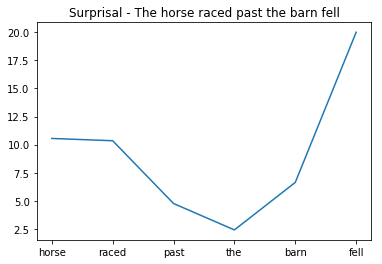

In [188]:
plt.plot(range(1,len(sent_list)), surprisals)
plt.xticks(range(1,len(sent_list)), sent_list[1:])
plt.title("Surprisal - The horse raced past the barn fell")
plt.show()

Indeed that is what we precict! The surprisal of "fell" is much higher than the rest of the words in the sentence indicating that it was very unexpected. A quick sanity check that let's us know this is working correctly is looking at the surprisal of the word "the", a common word, and has a low surprisal. Sweet!

Now, we can compare this to the disambiguated sentence:

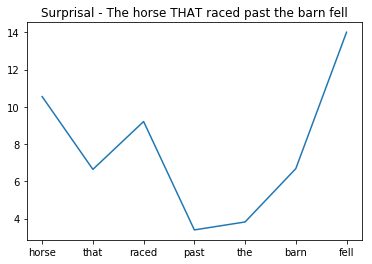

In [344]:
sent_list = "The horse that raced past the barn fell".split()
surprisals, probs = get_surprisal(sent_list)
plt.plot(range(1,len(sent_list)), surprisals)
plt.xticks(range(1,len(sent_list)), sent_list[1:])
plt.title("Surprisal - The horse THAT raced past the barn fell")
plt.show()

Interestingly, we still see a spike in surprisal of the word "fell". It is not quite as high, perhaps indicating that the model is taking into account something of the syntax. Maybe the sentence ending words did not rank as probable in this version of the language model, for instance. That said it is still quite high. Additionally, there is another spike in surprisal after the word "that". The magnitude of this surprisal is not huge, but it is definitely there. A similar effect can be found by looking at the word "barn"--relative to the words to its left, it has a high surprisal. These surprisals are not originating from the syntax--"that raced" is a perfectly syntactically valid construction. They must be evidence of a different kind of ambiguity. There are so many words that can follow the word "that"! Why should "raced" be any more common than "ate"? Similarly, why should "barn" be preferable to "field" or "finish line"? 

We need to take into account how many good possible options we have for the next word, and to do that we can use the measure of __perplexity__.


Perplexity, as Dan Jurafsky describes it, is akin to the "average branching factor" of a model has to consider when predicting the next word. If the perplexity of high, there are many choices for next words with similar probabilities, so it is more difficult for the model to predict what comes next. On the other hand, if the perplexity is low, then the model is pretty confident about the next word. The actual equation used to calculate perplexity is the exponentiation of the entropy:

$$ 2^{H(p)} $$

Where $H(p)$ is the information-theoretic entropy of the distribution, or the average surprisal:

$$H(p) = -\sum_{w \in V} p(w)\cdot log(p(w))$$

So, if we calculate surprisal and perplexity at every point in our sentence, we can get a sense of how "surprising" a word is compared to how surprising we expected it to be:
- If both are high, then we had a lot of probable options and just chose one, not super informative. 
- If both are low, we did not have a lot of probable options and just chose one that was very common. 
- If perplexity is high, and surprisal is low, that would be kind of strange, because we have a lot of possible options, but perhaps the one we chose was more probable than the others. 
- Finally, if perplexity is low and surprisal is high, then we did not have a lot of different probable option (i.e. we kind of knew what was coming next), but the next word was still very informative and unexpected.

The last case neatly lines up with our garden path effect! We think we know where a sentence is going, but suddely it ends up somewhere else. Let's take another look at our surprisals in light of this disucssion.

In [190]:
def perplexity(probs):
    """
    probs is a torch tensor, so we have to convert it to a numpy array and detach the gradient
    """
    entropy = sum(p * np.log2(p) if p > 0 else 0 for p in probs.detach().numpy())
    return 2 ** -entropy

In [254]:
def plot_pp_surp(sent):
    """
    plot the incremental perplexity and surprisal of a given sentence underneath each other
    """
    sent = sent.split(" ")
    surprisals, probabilities = get_surprisal(sent)
    pps = [perplexity(prob_dist.flatten()) for prob_dist in probabilities]
    print("surprisals:", surprisals)
    print("perplexities:", pps[:-1])
    # graphing
    # pp subplot - shifted one to right to get perplexity AT word (want to know: when we 
    # chose this word, what was the average branching factor? or how hard should it have been to choose this word?)
    plt.subplot(2, 1, 1)
    plt.plot(range(1, len(sent)), pps[:-1], label="avg")
    # plt.plot(range(1, len(sent)), np.power(2, surprisals), label="word")
    plt.xticks(range(1, len(sent)), sent[1:])
    plt.ylim(0, 1500)
    #plt.legend()
    plt.title("Perplexity - %s"%(" ".join(sent)))
    
    # surprisal subplot
    plt.subplot(2, 1, 2)
    plt.plot(range(1, len(sent)), surprisals, label="word surprisal")
    plt.plot(range(1, len(sent)), np.log2(pps[:-1]), label="entropy")
    plt.xticks(range(1, len(sent)), sent[1:])
    plt.legend()
    plt.title("Surprisal - %s"%(" ".join(sent)))
    
    plt.tight_layout() # avoids overlap
    plt.show()

surprisals: [10.54796505332892, 10.345239978589484, 4.759155399114188, 2.410015756747987, 6.638949901119871, 19.997773855146455]
perplexities: [2696.0325628993974, 151.3371317456799, 43.47638077268655, 37.217403537470325, 1358.7343833653244, 11.153028343336652]


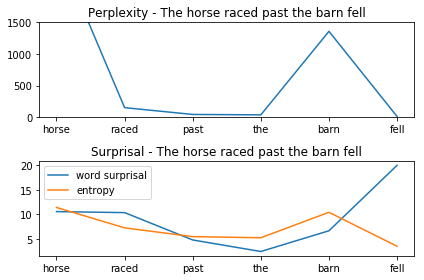

In [255]:
plot_pp_surp("The horse raced past the barn fell")

There we go! Now we can see that the surprisal increase at "barn" was somewhat warrented, as there was a high perplexity, so many words were likely to be chosen. However, for the word "fell", there was a low perplexity, but a high surprisal--exactly what we said we expected for a garden path effect.

Note: the perplexity of a word is the perplexity BEFORE the word was chosen. i.e. when deciding that the next word was "barn" after "the" there were many words assigned even probabilities, but "barn" was the one chosen.\

Also plotted on the surprisal graph is the average surprisal, or entropy, which is the log2 of perplexity

Let's see how this compares to the version of this sentence without the effect:

surprisals: [10.54796505332892, 6.643647170753685, 9.211768865096262, 3.3946774976170135, 3.8218403197570168, 6.683358419553217, 14.001688309271648]
perplexities: [2696.0325628993974, 151.3371317456799, 222.2516777071844, 46.74033217217957, 33.62912943000506, 975.0484886984677, 14.171326395798566]


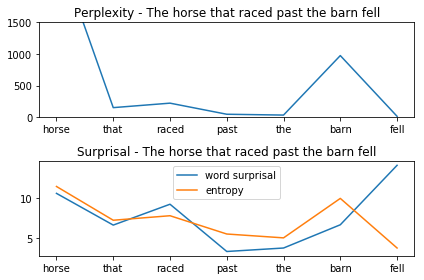

In [256]:
plot_pp_surp("The horse that raced past the barn fell")

Huh, so we see a very similar effect. After the word "that" we have slight increase in perplexity that is somewhat matched by the surprisal of "raced" (but even that has a relatively high surprisal). Interestingly, the word "fell" still has a high surprisal even though the perplexity is relatively low. Is this an example of failure to learn or take into account syntax? Or is "fell" just a very infrequent word in this context?

Another way we could look at the difference between these two distributions is by calculating the KL-Divergence

In [245]:
def cross_entropy(p, q):
    return -sum(p[i] * np.log2(q[i]) if q[i] != 0 else 0 for i in range(len(p)))

In [ ]:
def kl_div(p, q):
    return cross_entropy(p, q) - cross_entropy(p, p)

In [288]:
# test
p = [0.25, 0.25, 0.25, 0.25]
q = [0.49, 0.49, 0.01, 0.01]
cross_entropy(p, q)

3.8365012677171206

In [231]:
sent1 = "The horse raced past the barn fell".split(" ")
sent2 = "The horse that raced past the barn fell".split(" ")
sp1, p1 = get_surprisal(sent1)
sp2, p2 = get_surprisal(sent2)

In [277]:
p1_np = [p.detach().numpy().flatten() for p in p1]
p2_np = [p.detach().numpy().flatten() for p in p2]

In [284]:
sent1_probs = dict(zip(sent1, p1_np))
sent2_probs = dict(zip(sent2, p2_np))

In [290]:
# sent1 is the shorter garden path version so we iterate over it:
print("word\tDIV_kl(gp, ngp)\tDIV_kl(ngp gp)")
for word in sent1:
    print(word, kl_div(sent1_probs[word], sent2_probs[word]), kl_div(sent2_probs[word], sent1_probs[word]), sep="\t")

word	DIV_kl(gp, ngp)	DIV_kl(ngp gp)
The	0.0	0.0
horse	0.0	0.0
raced	0.5508232598864273	0.5704328383400252
past	0.34396030780165354	0.46240853918018576
the	0.10742160183058047	0.10866557576429337
barn	0.23600627442564726	0.42635918920371374
fell	0.26456649345619443	0.20935524599306277


As expected, the $Div_{KL}$ is 0 for the first two words until the word "that" in the disambiguated garden path (that  is because this model is deterministic--what would happen if it weren't?). Initially, the divergence is pretty high, but it is not too high at the garden path effect onset word "fell", which seems to indicate that the distributions over words are similar. (I don't really have a sense of scale here but relative to the other kl divergences in the sentenc, it is pretty low.

It appears that information-theoretic explanations aren't enough to reproduce the garden path effect. We can see if parts of speech are enough, though

In [292]:
import nltk
from collections import Counter



['The', 'horse', 'raced', 'past', 'the', 'barn', 'fell']

In [328]:
probs, words = get_top_k_nw(" ".join(sent1[:-1]), k= 100, verbose=False)

pos_counter = Counter()

for word in words:
    pos_counter[nltk.pos_tag(sent1[:-1] + [word])[-1][1]] += 1

    

In [330]:
print(" ".join(sent1[:-1]))
pos_counter.most_common()

The horse raced past the barn


[('IN', 28),
 ('NN', 20),
 ('RB', 15),
 ('NNS', 5),
 ('VBG', 5),
 (':', 4),
 ('CC', 3),
 ('.', 3),
 ('RP', 3),
 ('PRP', 3),
 ('WRB', 2),
 ('DT', 2),
 ('CD', 2),
 (',', 1),
 ('TO', 1),
 ('POS', 1),
 ('WDT', 1),
 ('(', 1)]

In [331]:
probs, words = get_top_k_nw(" ".join(sent2[:-1]), k=100, verbose=False)

pos_counter = Counter()

for word in words:
    pos_counter[nltk.pos_tag(sent2[:-1] + [word])[-1][1]] += 1
    #print(nltk.pos_tag([word]))
    


In [333]:
print(" ".join(sent2[:-1]))
pos_counter.most_common()

The horse that raced past the barn


[('IN', 25),
 ('VBD', 16),
 ('RB', 13),
 ('NN', 11),
 (':', 4),
 ('.', 3),
 ('CC', 3),
 ('NNS', 3),
 ('RP', 3),
 ('PRP', 3),
 ('WRB', 2),
 ('DT', 2),
 ('MD', 2),
 ('VBG', 2),
 (',', 1),
 ('TO', 1),
 ('POS', 1),
 ('VBZ', 1),
 ('RBR', 1),
 ('JJ', 1),
 ('CD', 1),
 ('(', 1)]

In [341]:
def get_common_pos_continuation(sent, k=100, use_prob=True):
    probs, words = get_top_k_nw(" ".join(sent[:-1]), k=k, verbose=False)

    pos_counter = Counter()

    for prob, word in zip(probs, words):
        if use_prob:
            pos_counter[nltk.pos_tag(sent[:-1] + [word])[-1][1]] += prob
        else:
            pos_counter[nltk.pos_tag(sent[:-1] + [word])[-1][1]] += 1

    print(" ".join(sent[:-1]))
    return pos_counter.most_common()

In [342]:
get_common_pos_continuation(sent1)

The horse raced past the barn


[(',', 0.2947661876678467),
 ('CC', 0.26670204047695734),
 ('.', 0.1998679690004792),
 ('IN', 0.10547207421041094),
 ('TO', 0.03086026944220066),
 ('NN', 0.020269874163204804),
 ('RB', 0.01211586463614367),
 ('NNS', 0.011384120211005211),
 ('WRB', 0.010342082241550088),
 (':', 0.009320501601905562),
 ('POS', 0.004707637708634138),
 ('RP', 0.002862816385459155),
 ('VBG', 0.0018548359221313149),
 ('PRP', 0.001333121646894142),
 ('DT', 0.0013047613902017474),
 ('CD', 0.0004436047456692904),
 ('WDT', 0.0003423518792260438),
 ('(', 0.0002191850362578407)]

In [343]:
get_common_pos_continuation(sent2)

The horse that raced past the barn


[('.', 0.36123612843221053),
 (',', 0.22027510404586792),
 ('CC', 0.14834860566770658),
 ('IN', 0.10196639996138401),
 ('VBD', 0.03729178989306092),
 ('TO', 0.02398907020688057),
 ('NN', 0.01160953682847321),
 ('RB', 0.011437216773629189),
 (':', 0.009822221414651722),
 ('NNS', 0.005479565967107192),
 ('WRB', 0.004753141198307276),
 ('POS', 0.003645336488261819),
 ('RP', 0.0034749338519759476),
 ('DT', 0.0025445548817515373),
 ('PRP', 0.0019074046576861292),
 ('MD', 0.0012327066215220839),
 ('VBG', 0.0010197200172115117),
 ('VBZ', 0.0006797077367082238),
 ('RBR', 0.00041356898145750165),
 ('JJ', 0.00040901845204643905),
 ('CD', 0.00035079283406957984),
 ('(', 0.0003223808598704636)]

Here are some other garden path sentences:

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


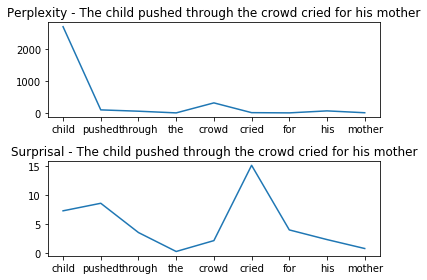

In [68]:
plot_pp_surp("The child pushed through the crowd cried for his mother")

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


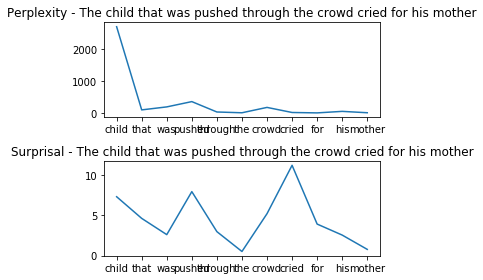

In [69]:
plot_pp_surp("The child that was pushed through the crowd cried for his mother")

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


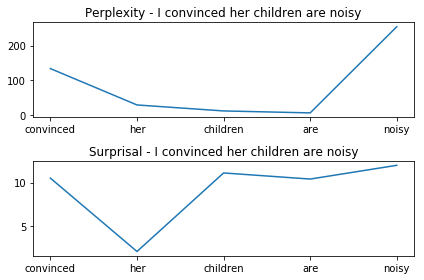

In [75]:
plot_pp_surp("I convinced her children are noisy")

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


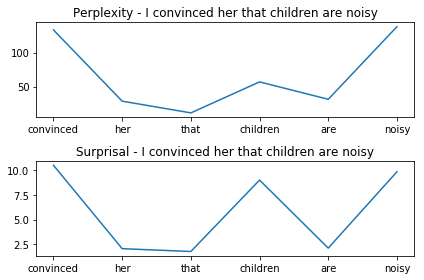

In [78]:
plot_pp_surp("I convinced her that children are noisy")

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


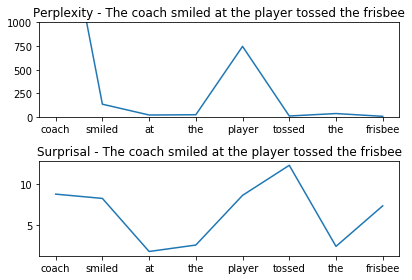

In [85]:
plot_pp_surp("The coach smiled at the player tossed the frisbee")

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


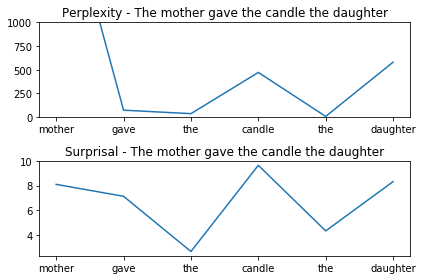

In [88]:
plot_pp_surp("The mother gave the candle the daughter")

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


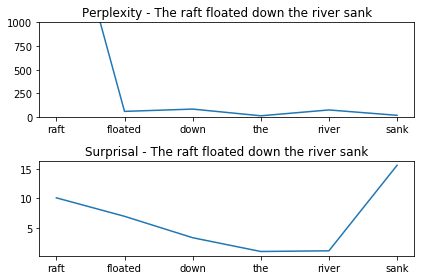

In [90]:
plot_pp_surp("The raft floated down the river sank")

/Users/benjaminnewman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


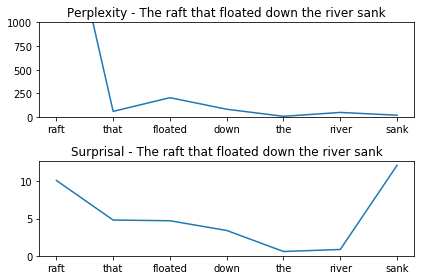

In [93]:
plot_pp_surp("The raft that floated down the river sank")

In [295]:
get_top_k_nw("The horse that raced past the barn", 50)

The horse that raced past the barn
	....</w> (0.3594)
	...,</w> (0.2203)
	...and</w> (0.1462)
	...to</w> (0.0240)
	...was</w> (0.0233)
	...with</w> (0.0160)
	...at</w> (0.0138)
	...in</w> (0.0125)
	...toward</w> (0.0091)
	...as</w> (0.0089)
	...on</w> (0.0087)
	...door</w> (0.0075)
	...into</w> (0.0059)
	...before</w> (0.0059)
	...had</w> (0.0057)
	...-</w> (0.0046)
	...that</w> (0.0043)
	...;</w> (0.0042)
	...doors</w> (0.0037)
	...'s</w> (0.0036)
	...where</w> (0.0029)
	...without</w> (0.0027)
	...but</w> (0.0019)
	...when</w> (0.0018)
	...just</w> (0.0017)
	...back</w> (0.0017)
	...out</w> (0.0016)
	...came</w> (0.0015)
	...next</w> (0.0015)
	...then</w> (0.0015)
	...towards</w> (0.0014)
	...so</w> (0.0014)
	...?</w> (0.0013)
	...a</w> (0.0013)
	...for</w> (0.0013)
	...the</w> (0.0013)
	...while</w> (0.0013)
	...like</w> (0.0012)
	...again</w> (0.0012)
	...until</w> (0.0011)
	...from</w> (0.0011)
	...after</w> (0.0010)
	...he</w> (0.0010)
	...through</w> (0.0010)
	...down</w> (0.001